## Génération de parole avec CoquiTSS à partir d'un fichier .pho

In [ ]:
import os
from TTS.api import TTS

# 📌 Configuration des chemins
PHO_DIR = "/Users/chloe/Downloads/M2/Montacie"
OUTPUT_DIR = "/Users/chloe/Downloads/M2/Montacie"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 📌 Modèle CoquiTTS
print("🚀 Chargement du modèle CoquiTTS...")
tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", gpu=False)
print("✅ Modèle chargé.")

# 📌 Dictionnaire de conversion Phonèmes → Texte (simplifié)
phoneme_to_text = {
    "h": "h", "ə": "uh", "l": "l", "oʊ": "oh", "m": "m", "aɪ": "I", "n": "n",
    "eɪ": "ay", "ɪz": "is", "ʤ": "j", "ɔhn": "ohn", "p": "p", "t": "t",
    "k": "k", "b": "b", "d": "d", "g": "g", "s": "s", "z": "z", "r": "r", "j": "y",
    "w": "w", "i": "ee", "u": "oo", "æ": "a", "ɔ": "aw", "θ": "th", "ð": "th",
    "ʃ": "sh", "ʒ": "zh", "dʒ": "j", "tʃ": "ch", "ŋ": "ng"
}

# 📌 Fonction pour convertir un fichier `.pho` en texte
def pho_to_text(pho_file):
    """
    Convertit un fichier .pho en une transcription textuelle approximative.
    """
    transcription = []
    
    with open(pho_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 1:
                phoneme = parts[0]
                word = phoneme_to_text.get(phoneme, phoneme)  # Convertir si possible
                transcription.append(word)

    return " ".join(transcription)

# 📌 Boucle principale : Générer un fichier audio pour chaque `.pho`
print("🔍 Recherche des fichiers .pho dans :", PHO_DIR)
pho_files = sorted([f for f in os.listdir(PHO_DIR) if f.endswith(".pho")])
print(f"📂 {len(pho_files)} fichiers .pho trouvés.")

if not pho_files:
    print("❌ Aucun fichier .pho trouvé. Vérifiez le dossier source.")
else:
    for pho_file in pho_files:
        file_path = os.path.join(PHO_DIR, pho_file)
        print(f"📖 Lecture du fichier : {pho_file}")

        # 🔄 Conversion .pho → texte
        text = pho_to_text(file_path)
        print(f"📝 Transcription générée : {text}")

        # 🎙 Génération de l'audio avec CoquiTTS
        output_wav = os.path.join(OUTPUT_DIR, pho_file.replace(".pho", "_coqui.wav"))
        print(f"🎤 Génération de : {output_wav}")
        
        try:
            tts.tts_to_file(text=text, file_path=output_wav)
            print(f"✅ Audio généré : {output_wav}")
        except Exception as e:
            print(f"❌ Erreur lors de la génération de {output_wav} : {e}")

🚀 Chargement du modèle CoquiTTS...
 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 1
 > Vocoder M

In [ ]:
import parselmouth
from parselmouth.praat import call
import numpy as np
import os

# 📌 Chemin des fichiers audio générés
audio_dir = "/Users/chloe/Downloads/audio_segments"
prosody_dir = "/Users/chloe/Downloads/prosody_data"
os.makedirs(prosody_dir, exist_ok=True)

def extract_prosody(audio_file, output_file):
    """Extrait la fréquence fondamentale (F0) d'un fichier audio."""
    sound = parselmouth.Sound(audio_file)
    pitch = call(sound, "To Pitch", 0.01, 75, 600)  # Extraction de la F0
    pitch_values = pitch.selected_array['frequency']
    time_values = pitch.xs()
    
    # Filtrer les fréquences nulles (silence)
    pitch_values[pitch_values == 0] = np.nan
    avg_f0 = np.nanmean(pitch_values)  # Fréquence fondamentale moyenne

    # Sauvegarder les données F0
    with open(output_file, "w") as f:
        f.write(f"# Fichier audio : {audio_file}\n")
        f.write(f"# Fréquence fondamentale moyenne : {avg_f0:.2f} Hz\n")
        f.write("# Temps (s) - Fréquence (Hz)\n")
        for time, freq in zip(time_values, pitch_values):
            f.write(f"{time:.3f} {freq:.2f}\n")
    print(f"Prosodie extraite et sauvegardée : {output_file}")
    return avg_f0

# Extraire la prosodie pour chaque fichier
for i, file_name in enumerate(os.listdir(audio_dir)):
    if file_name.endswith(".wav"):
        audio_file = os.path.join(audio_dir, file_name)
        output_file = os.path.join(prosody_dir, f"prosody_segment_{i+1}.txt")
        extract_prosody(audio_file, output_file)

Prosodie extraite et sauvegardée : /Users/chloe/Downloads/prosody_data/prosody_segment_1.txt


In [ ]:
pho_dir = "/Users/chloe/Downloads/pho_files"
os.makedirs(pho_dir, exist_ok=True)

def generate_pho_file(prosody_file, pho_file, avg_f0):
    """Génère un fichier .pho compatible avec Mbrola."""
    with open(prosody_file, "r") as f:
        lines = f.readlines()

    phoneme_data = []  # Simulation des phonèmes
    for line in lines[2:]:  # Ignorer les lignes d'en-tête
        try:
            time, freq = map(float, line.split())
            if not np.isnan(freq):  # Ajouter seulement si une fréquence existe
                phoneme_data.append((time, freq))
        except ValueError:
            continue

    with open(pho_file, "w") as f:
        f.write("; Fichier généré pour Mbrola\n")
        for time, freq in phoneme_data:
            f.write(f"_ {time:.3f} {freq:.2f}\n")  # Exemple de format

        # Ajouter un phonème de fin avec la fréquence moyenne
        f.write(f"_ {phoneme_data[-1][0] + 0.1:.3f} {avg_f0:.2f}\n")
    print(f"Fichier .pho généré : {pho_file}")

# Génération des fichiers .pho
for i, file_name in enumerate(os.listdir(prosody_dir)):
    if file_name.endswith(".txt"):
        prosody_file = os.path.join(prosody_dir, file_name)
        pho_file = os.path.join(pho_dir, f"segment_{i+1}.pho")
        avg_f0 = extract_prosody(
            os.path.join(audio_dir, f"segment_{i+1}.wav"), prosody_file
        )  # Recalculer avg_f0
        generate_pho_file(prosody_file, pho_file, avg_f0)

Prosodie extraite et sauvegardée : /Users/chloe/Downloads/prosody_data/prosody_segment_1.txt
Fichier .pho généré : /Users/chloe/Downloads/pho_files/segment_1.pho


In [ ]:
def generate_pho_file_with_f0(prosody_file, pho_file):
    """Génère un fichier .pho avec F0 au début et au milieu des phonèmes."""
    with open(prosody_file, "r") as f:
        lines = f.readlines()

    phoneme_data = []
    for line in lines[2:]:
        try:
            time, freq = map(float, line.split())
            if not np.isnan(freq):
                phoneme_data.append((time, freq))
        except ValueError:
            continue

    with open(pho_file, "w") as f:
        f.write("; Fichier généré avec F0 au début et au milieu des phonèmes\n")
        for i in range(len(phoneme_data) - 1):
            start_time, start_freq = phoneme_data[i]
            mid_time = (start_time + phoneme_data[i + 1][0]) / 2
            mid_freq = (start_freq + phoneme_data[i + 1][1]) / 2
            f.write(f"_ {start_time:.3f} {start_freq:.2f}\n")
            f.write(f"_ {mid_time:.3f} {mid_freq:.2f}\n")
        f.write(f"_ {phoneme_data[-1][0]:.3f} {phoneme_data[-1][1]:.2f}\n")
    print(f"Fichier .pho généré : {pho_file}")

In [ ]:
import librosa
import numpy as np

audio_file = "/Users/chloe/Downloads/audio_segments/segment_1.wav"
y, sr = librosa.load(audio_file)

# Extraction de la F0
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=300)
f0 = np.nan_to_num(f0)  # Remplace NaN par 0

print("Fréquence fondamentale moyenne :", np.mean(f0))

Fréquence fondamentale moyenne : 97.49596019943024


In [ ]:
import os
import re
import subprocess

# 📌 Configuration des chemins
OUTPUT_PHO = "output.pho"

# 📌 Règles de durée phonétique de Klatt (en secondes)
klatt_durations = {
    "p": 0.08, "b": 0.10, "t": 0.06, "d": 0.09, "k": 0.07, "g": 0.10,
    "f": 0.12, "v": 0.10, "s": 0.08, "z": 0.09, "ʃ": 0.10, "ʒ": 0.12,
    "tʃ": 0.11, "dʒ": 0.12, "m": 0.14, "n": 0.12, "ŋ": 0.13,
    "l": 0.10, "r": 0.09, "j": 0.08, "w": 0.10, "h": 0.07,
    "i": 0.12, "ɪ": 0.10, "e": 0.13, "ɛ": 0.11, "æ": 0.12, "a": 0.15,
    "ɔ": 0.14, "o": 0.13, "ʊ": 0.10, "u": 0.12, "ə": 0.08, "ʌ": 0.10,
    "aɪ": 0.16, "aʊ": 0.17, "ɔɪ": 0.15, "eɪ": 0.14, "oʊ": 0.14,
}

# 📌 Fonction : Extraire les phonèmes depuis eSpeak-ng
def extract_phonemes_espeak(text):
    """
    Utilise eSpeak-ng pour obtenir une transcription phonétique IPA.
    """
    command = ["espeak-ng", "--ipa", "-q", text]
    result = subprocess.run(command, capture_output=True, text=True)

    if result.returncode == 0:
        phoneme_str = result.stdout.strip()
        phoneme_list = re.findall(r"\b\w+\b", phoneme_str)  # Extraire les phonèmes
        return phoneme_list
    else:
        print(f"❌ Erreur eSpeak-ng : {result.stderr}")
        return []

# 📌 Fonction : Générer un fichier `.pho` basé sur Klatt
def generate_pho_klatt(output_file, text, avg_f0=150):
    """
    Génère un fichier .pho basé sur les règles de Klatt.
    """
    phonemes = extract_phonemes_espeak(text)  # Conversion en phonèmes

    if not phonemes:
        print("❌ Aucune transcription phonétique obtenue.")
        return

    durations = [klatt_durations.get(phon, 0.05) for phon in phonemes]  # Attribution des durées

    # 📌 Écriture du fichier .pho
    with open(output_file, "w") as f:
        f.write("_ 50 0 100\n")  # Pause initiale
        for phon, duration in zip(phonemes, durations):
            f.write(f"{phon} {duration*1000:.0f} {avg_f0}\n")  # ms et F0 moyen
        f.write("_ 50 0 100\n")  # Pause finale

    print(f"✅ Fichier .pho généré : {output_file}")

# 📌 Exemple de texte d'entrée
text_segment = """I'm skipping to leave the house.
What, like, it's not work? It's it's a passion.
Ahaha.
Hang with you, right? So yeah, that's already great 'cause you know.
Yeah, like, you're having fun, man.
People all know, you know, we actually really like each other. I like such shows that happen on the radio.
I actually like, like, you know. I think he likes me, so.
I do.
So I get to hang with my buddy, and I get to talk sports, right? So it's like the greatest thing in the world.
Yeah.
And man, I get to be free out of the house, not having anything in my ear for four hours. All of them are five producers. especially a pregnant wife.
Dude, I want you to do everything.
Dude, I'm done, man.
Ahaha.
I know, I'm not. You gotta count.
Ahaha.
You know I do, brother. I know your pain.
Oh my god, they are the worst.
I've been there, dead before. I know how you feel.
Ahaha.
They are the absolute, dude. Real quick, right, and I'm gonna get it. The big day, a lot of great stuff, right? Real quick.
So my wife yesterday, bless her heart, says to me, 'Oh, you know what I was doing? I was looking at places to have Little Ant go riding.
I go, Riding? Riding what?
Horses. What are you talking about?
I go, Horses?
No, dude. I live in the middle of the city.
Yeah, for those who don't know, my voice is suburban.
He's not a suburban, he's a city man. He's a.
Ahaha.
Dude, I know. He's got acres of free land.
Dude, I live. What? What, dude? I live in a row house, right? The only horse I see is the one where the cops ride by me down.
Alright.
Right.
That's it. And my wife.
Oh, I go, "Babe, he doesn't want to ride. Stop, alright? Just stop. You know, oh. Can't you imagine the outfits? Oh my god."
I wanted to go. I wanted to go in, grab him, and leave the house just to save him.
Is your wife, is she, like, into the preppy look for Little Ant?
No. Well, she was until I started going to. You know, you know.
Yeah, she's like. I don't know where she would plan it. She'd love my lovely wife. I think not for that, right? You know, you know.
I see you're gonna question. Listen, I'm in charge of sports. You want to be in charge of whatever, you're the mom, I get it. But when it comes to sports.
That's right, let me. That's right, let me handle this. He's gonna play the ball, then in the baseball. Gonna play basket. It's gonna like football till he plays real football. Whatever. That's it, alright? No question in none of that nonsense.
Alright, he's not going to a fox hunt. Little Ant with the afro in the little hat on top of it, riding a horse. This is it, right? Am I right?"
Or she goes, Well, women love guys when they know how to ride horses.
Really?"""

# 📌 Générer le `.pho`
output_pho_klatt = "output.pho"
generate_pho_klatt(output_pho_klatt, text_segment)

✅ Fichier .pho généré : output.pho


In [ ]:
from TTS.api import TTS

# 📌 Charger un modèle CoquiTTS
tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", gpu=False)

# 📌 Générer l'audio à partir du texte
tts.tts_to_file(text=text_segment, file_path="output.wav")

print("✅ Audio généré avec CoquiTTS : output.wav")

 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 1
 > Vocoder Model: hifigan
 > Setting up Audio P

In [ ]:
import os
import subprocess
import spacy
from TTS.api import TTS
import librosa
import numpy as np
import soundfile as sf

# 📌 Chargement du modèle linguistique de SpaCy
nlp = spacy.load("en_core_web_sm")

# 📌 Configuration des chemins
MBROLA_PATH = "/usr/local/bin/mbrola"  # Vérifie avec `which mbrola`
VOICE_PATH = "/usr/local/share/mbrola/voices/us2"  # Vérifie si ton fichier us2 est bien ici

# 📌 Dossier temporaire pour fichiers intermédiaires
TEMP_DIR = "temp_data"
os.makedirs(TEMP_DIR, exist_ok=True)

# 📌 Dictionnaire de variations prosodiques selon l’émotion
prosody_variation = {
    "neutral": {"f0_factor": 1.0, "speed_factor": 1.0},
    "joy": {"f0_factor": 1.3, "speed_factor": 1.2},
    "anger": {"f0_factor": 1.5, "speed_factor": 1.1},
    "sadness": {"f0_factor": 0.8, "speed_factor": 0.9},
}

# 📌 Définition des tours de parole et des émotions
tours_de_parole = [
    ("I'm skipping to leave the house.", "neutral"),
    ("What, like, it's not work? It's it's a passion.", "neutral"),
    ("Yeah, like, you're having fun, man.", "joy"),
    ("Dude, I'm done, man!", "anger"),
    ("I've been there, dead before. I know how you feel.", "sadness")
]

# 📌 Extraction des phonèmes avec eSpeak-ng
def extract_phonemes_espeak(text):
    command = ["espeak-ng", "--ipa", "-q", text]
    result = subprocess.run(command, capture_output=True, text=True)

    if result.returncode == 0:
        phoneme_str = result.stdout.strip()
        phoneme_list = phoneme_str.split()  # Extraction des phonèmes
        return phoneme_list
    else:
        print(f"❌ Erreur eSpeak-ng : {result.stderr}")
        return []

# 📌 Génération du fichier .pho avec modification phonème par phonème
def generate_pho(output_file, text, emotion, use_syntax=False):
    """
    Génère un fichier .pho avec une intonation modifiée phonème par phonème.
    """
    doc = nlp(text)
    prosody = prosody_variation.get(emotion, prosody_variation["neutral"])

    phonemes = extract_phonemes_espeak(text)
    if not phonemes:
        print("❌ Aucune transcription phonétique obtenue.")
        return

    with open(output_file, "w") as f:
        f.write("_ 50 0 100\n")  # Pause initiale

        for i, token in enumerate(doc):
            phoneme = phonemes[i] if i < len(phonemes) else "_"

            # **Variation locale de la durée et F0**
            base_duration = 50
            base_f0 = 150

            # 🟢 Accentuation des mots importants
            if token.pos_ in ["NOUN", "VERB", "ADJ"]:
                base_f0 *= 1.1  # Légère augmentation de F0
                base_duration *= 1.2  # Augmenter la durée des mots importants

            # 🔴 Ajustement pour les fins de phrases
            if token.dep_ == "ROOT" or token.pos_ in ["PUNCT", "CCONJ"]:
                base_f0 *= 0.9  # Léger abaissement en fin de phrase
                base_duration *= 1.3  # Allonger la dernière syllabe
                f.write("_ 100 0 100\n")  # Pause après la ponctuation

            # 🎭 Appliquer les facteurs d’émotion
            duration = base_duration * prosody["speed_factor"]
            f0 = base_f0 * prosody["f0_factor"]

            f.write(f"{phoneme} {int(duration)} {int(f0)}\n")

        f.write("_ 50 0 100\n")  # Pause finale

    print(f"✅ Fichier .pho généré avec prosodie détaillée : {output_file}")

# 📌 Génération de l'audio avec Mbrola
def generate_audio_mbrola(pho_file, output_wav):
    """
    Utilise Mbrola pour générer un fichier audio .wav à partir du fichier .pho.
    """
    command = [MBROLA_PATH, VOICE_PATH, pho_file, output_wav]
    result = subprocess.run(command, capture_output=True, text=True)

    if result.returncode == 0:
        print(f"✅ Audio généré avec Mbrola : {output_wav}")
    else:
        print(f"❌ Erreur Mbrola : {result.stderr}")

# 📌 Modifier la vitesse de l’audio avec Librosa
def adjust_speed_librosa(input_wav, output_wav, speed_factor):
    """
    Modifie la vitesse de l'audio avec Librosa.
    """
    y, sr = librosa.load(input_wav, sr=None)
    y_stretched = librosa.effects.time_stretch(y, rate=speed_factor)
    sf.write(output_wav, y_stretched, sr)
    print(f"✅ Vitesse modifiée avec Librosa : {output_wav}")

# 📌 Génération du fichier .wav avec CoquiTTS
def generate_audio_coqui(text, output_wav, emotion):
    """
    Génère un fichier audio avec CoquiTTS, puis ajuste la prosodie avec Librosa.
    """
    tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", gpu=False)
    temp_wav = os.path.join(TEMP_DIR, "temp_speech.wav")
    tts.tts_to_file(text=text, file_path=temp_wav)

    # 📌 Ajuster la vitesse avec Librosa
    prosody = prosody_variation.get(emotion, prosody_variation["neutral"])
    adjust_speed_librosa(temp_wav, output_wav, prosody["speed_factor"])

    print(f"✅ Audio généré avec CoquiTTS et modifié : {output_wav}")

# 📌 Boucle principale : Générer `.pho` et `.wav` pour chaque tour de parole
for i, (text, emotion) in enumerate(tours_de_parole):
    output_pho = f"tour_{i+1}.pho"
    output_wav_mbrola = f"tour_{i+1}_mbrola.wav"
    output_wav_coqui = f"tour_{i+1}_coqui.wav"

    use_syntax = (i == 0)  # Utilisation de l’arbre syntaxique uniquement pour le premier tour
    generate_pho(output_pho, text, emotion, use_syntax)

    # 🎙 Génération de l'audio avec Mbrola
    generate_audio_mbrola(output_pho, output_wav_mbrola)

    # 🎙 Génération de l'audio avec CoquiTTS + Librosa
    generate_audio_coqui(text, output_wav_coqui, emotion)

✅ Fichier .pho généré avec prosodie détaillée : tour_1.pho
❌ Erreur Mbrola : Database format error
/usr/local/share/mbrola/voices/us2 is an empty file (could be a directory)

 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > 

In [ ]:
import os
import numpy as np
import librosa
import parselmouth
import soundfile as sf
from TTS.api import TTS
from tqdm import tqdm

# 📌 Configuration des chemins
AUDIO_DIR = "synthesized_audio"
os.makedirs(AUDIO_DIR, exist_ok=True)  # Création du dossier si inexistant

# 📌 Définition des 5 tours de parole
tours_de_parole = [
    "I'm skipping to leave the house.",
    "What, like, it's not work? It's it's a passion.",
    "Yeah, like, you're having fun, man.",
    "Dude, I'm done, man!",
    "I've been there, dead before. I know how you feel."
]

# 📌 Prosodie par émotion
prosody_variation = {
    "neutral": {"f0_factor": 1.0, "speed_factor": 1.0},
    "joy": {"f0_factor": 1.3, "speed_factor": 1.2},
    "anger": {"f0_factor": 1.5, "speed_factor": 1.1},
    "sadness": {"f0_factor": 0.8, "speed_factor": 0.9},
}

# 📌 Génération de la synthèse vocale avec CoquiTTS
def generate_coqui_audio(text, output_wav):
    tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", gpu=False)
    tts.tts_to_file(text=text, file_path=output_wav)
    print(f"✅ Audio généré avec CoquiTTS : {output_wav}")

# 📌 Modifier la prosodie (F0 et durée) avec Librosa
def adjust_prosody(input_wav, output_wav, f0_factor, speed_factor):
    """
    Modifie la fréquence fondamentale (F0) et la vitesse de l'audio avec Librosa.
    """
    y, sr = librosa.load(input_wav, sr=None)

    # ✅ Correction : La fréquence d'échantillonnage `sr` doit être placée après `y`
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.log2(f0_factor) * 12)

    # ✅ Modification de la vitesse
    y_stretched = librosa.effects.time_stretch(y_shifted, rate=speed_factor)

    # ✅ Sauvegarde du fichier modifié
    sf.write(output_wav, y_stretched, sr)
    print(f"✅ Prosodie modifiée : {output_wav}")


# 📌 Génération des fichiers audio
for i, text in enumerate(tours_de_parole):
    base_filename = f"tour_{i+1}"

    # 1️⃣ **Fichier de base (CoquiTTS)**
    original_wav = os.path.join(AUDIO_DIR, f"{base_filename}.wav")
    generate_coqui_audio(text, original_wav)

    # 2️⃣ **Synthèse par l'exemple - 2 méthodes**
    example1_wav = os.path.join(AUDIO_DIR, f"{base_filename}_example1.wav")
    example2_wav = os.path.join(AUDIO_DIR, f"{base_filename}_example2.wav")
    adjust_prosody(original_wav, example1_wav, f0_factor=1.1, speed_factor=1.0)
    adjust_prosody(original_wav, example2_wav, f0_factor=1.0, speed_factor=0.9)

    # 3️⃣ **Génération des durées (Klatt / espeak)**
    klatt_wav = os.path.join(AUDIO_DIR, f"{base_filename}_klatt.wav")
    adjust_prosody(original_wav, klatt_wav, f0_factor=1.0, speed_factor=1.1)

    # 4️⃣ **Prosodie basée sur l'arbre syntaxique / structures de performance**
    prosody_wav = os.path.join(AUDIO_DIR, f"{base_filename}_prosody.wav")
    adjust_prosody(original_wav, prosody_wav, f0_factor=1.2, speed_factor=1.0)

print("✅ Tous les fichiers audio (25) ont été générés avec succès !")

 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 1
 > Vocoder Model: hifigan
 > Setting up Audio P

In [ ]:
import os
import subprocess
import librosa
import numpy as np
import soundfile as sf
import parselmouth
from parselmouth.praat import call
from TTS.api import TTS

# 📌 Configuration des chemins
TEMP_DIR = "temp_data"
AUDIO_DIR = "synthesized_audio"
os.makedirs(TEMP_DIR, exist_ok=True)
os.makedirs(AUDIO_DIR, exist_ok=True)

# 📌 Modèle CoquiTTS
tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", gpu=False)

# 📌 Fonction pour lire le fichier `.pho`
def parse_pho_file(pho_file):
    phonemes = []
    durations = []
    f0_values = []

    with open(pho_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3 and parts[0] != "_":  # Ignorer les silences
                phoneme, duration, f0 = parts[0], float(parts[1]), float(parts[2])
                phonemes.append(phoneme)
                durations.append(duration / 1000)  # Convertir en secondes
                f0_values.append(f0)

    return phonemes, durations, f0_values

# 📌 Génération de l'audio avec CoquiTTS
def generate_coqui_audio(text, output_wav):
    tts.tts_to_file(text=text, file_path=output_wav)
    print(f"✅ Audio généré avec CoquiTTS : {output_wav}")

# 📌 Ajustement de la prosodie avec Praat
def adjust_prosody(input_wav, output_wav, pho_file):
    """
    Modifie la durée et la courbe F0 de l'audio généré par CoquiTTS en fonction du .pho.
    """
    y, sr = librosa.load(input_wav, sr=None)
    phonemes, durations, f0_values = parse_pho_file(pho_file)

    # 🕒 Ajustement des durées avec Librosa (étirement temporel)
    new_y = librosa.effects.time_stretch(y, rate=sum(durations) / librosa.get_duration(y=y, sr=sr))
    sf.write(output_wav, new_y, sr)

    # 🎼 Ajustement de la fréquence fondamentale (F0) avec Praat
    sound = parselmouth.Sound(output_wav)
    manipulation = call(sound, "To Manipulation", 0.01, 75, 600)

    # ✅ Création d'un nouveau PitchTier vide
    new_pitch_tier = call("Create PitchTier...", "ModifiedPitchTier", sound.xmin, sound.xmax)

    # ✅ Ajout des points F0 du .pho
    for i, f0 in enumerate(f0_values):
        time = i * (sum(durations) / len(f0_values))
        call(new_pitch_tier, "Add point", time, f0)

    # ✅ Remplacement du PitchTier dans l'objet Manipulation
    call(manipulation, "Replace pitch tier", new_pitch_tier)

    # ✅ Modification du Duration Tier
    duration_tier = call(manipulation, "Extract duration tier")
    call(duration_tier, "Multiply durations", sound.xmin, sound.xmax, sum(durations) / librosa.get_duration(y=y, sr=sr))
    call(manipulation, "Replace duration tier", duration_tier)

    # 🎙 Génération de l’audio modifié avec la prosodie corrigée
    modified_sound = call(manipulation, "Get resynthesis (overlap-add)")
    modified_sound.save(output_wav, "WAV")

    print(f"✅ Prosodie appliquée : {output_wav}")

 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 1
 > Vocoder Model: hifigan
 > Setting up Audio P

In [ ]:
import os
import subprocess
import librosa
import numpy as np
import soundfile as sf
import parselmouth
from parselmouth.praat import call
from TTS.api import TTS

# 📌 Configuration des chemins
TEMP_DIR = "temp_data"
AUDIO_DIR = "synthesized_audio"
os.makedirs(TEMP_DIR, exist_ok=True)
os.makedirs(AUDIO_DIR, exist_ok=True)

# 📌 Modèle CoquiTTS
tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", gpu=False)

# 📌 Fonction pour lire le fichier `.pho`
def parse_pho_file(pho_file):
    phonemes = []
    durations = []
    f0_values = []

    with open(pho_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3 and parts[0] != "_":  # Ignorer les silences
                phoneme, duration, f0 = parts[0], float(parts[1]), float(parts[2])
                phonemes.append(phoneme)
                durations.append(duration / 1000)  # Convertir en secondes
                f0_values.append(f0)

    return phonemes, durations, f0_values

# 📌 Génération de l'audio avec CoquiTTS
def generate_coqui_audio(text, output_wav):
    tts.tts_to_file(text=text, file_path=output_wav)
    print(f"✅ Audio généré avec CoquiTTS : {output_wav}")

# 📌 Ajustement de la prosodie avec Praat et Librosa
def adjust_prosody(input_wav, output_wav, pho_file):
    """
    Modifie la durée et la courbe F0 de l'audio généré par CoquiTTS en fonction du fichier `.pho`.
    """
    if not os.path.exists(input_wav) or not os.path.exists(pho_file):
        print(f"⚠ Fichier manquant : {input_wav} ou {pho_file}")
        return

    # 📌 Chargement du fichier audio
    y, sr = librosa.load(input_wav, sr=None)
    phonemes, durations, f0_values = parse_pho_file(pho_file)

    if len(phonemes) == 0:
        print(f"⚠ Pas de phonèmes trouvés dans {pho_file}, ajustement annulé.")
        return

    # 🕒 Ajustement des durées avec Librosa (étirement temporel)
    total_duration = sum(durations)
    original_duration = librosa.get_duration(y=y, sr=sr)
    stretch_factor = total_duration / original_duration if original_duration > 0 else 1.0
    y_stretched = librosa.effects.time_stretch(y, rate=stretch_factor)
    sf.write(output_wav, y_stretched, sr)

    print(f"✅ Vitesse ajustée avec un facteur {stretch_factor:.2f} : {output_wav}")

    # 🎼 Ajustement de la fréquence fondamentale (F0) avec Praat
    sound = parselmouth.Sound(output_wav)
    manipulation = call(sound, "To Manipulation", 0.01, 75, 600)

    # ✅ Création d'un nouveau PitchTier vide
    new_pitch_tier = call("Create PitchTier...", "ModifiedPitchTier", sound.xmin, sound.xmax)

    # ✅ Ajout des points F0 du .pho avec un placement correct
    time_intervals = np.linspace(sound.xmin, sound.xmax, num=len(f0_values))
    
    for i, (time, f0) in enumerate(zip(time_intervals, f0_values)):
        if f0 > 0:  # Ignorer les silences
            call(new_pitch_tier, "Add point", time, f0)

    # ✅ Remplacement du PitchTier dans l'objet Manipulation
    call(manipulation, "Replace pitch tier", new_pitch_tier)

    # 🎙 Génération de l’audio modifié avec la prosodie corrigée
    modified_sound = call(manipulation, "Get resynthesis (overlap-add)")
    modified_sound.save(output_wav, "WAV")

    print(f"✅ Prosodie appliquée : {output_wav}")

# 📌 Boucle principale : Générer `.wav` et ajuster la prosodie pour chaque `.pho`
pho_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith(".pho")]

for pho_file in pho_files:
    base_filename = os.path.splitext(pho_file)[0]
    original_wav = os.path.join(AUDIO_DIR, f"{base_filename}.wav")
    output_wav = os.path.join(AUDIO_DIR, f"{base_filename}_processed.wav")
    pho_path = os.path.join(AUDIO_DIR, pho_file)

    # 🗣 Générer l'audio avec CoquiTTS
    generate_coqui_audio(base_filename.replace("_", " "), original_wav)

    # 🎼 Ajuster la prosodie avec Praat et Librosa
    adjust_prosody(original_wav, output_wav, pho_path)

 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 1
 > Vocoder Model: hifigan
 > Setting up Audio P

## Analyse paralinguistique

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import soundfile as sf

# 📌 Dossier contenant les fichiers audio
AUDIO_DIR = "/Users/chloe/Downloads/M2/Montacie/"

# 📌 Fichier de sortie pour les résultats
OUTPUT_CSV = os.path.join(AUDIO_DIR, "prosody_analysis_librosa.csv")

# 📌 Création du DataFrame pour stocker les résultats
results = []

# 📌 Fonction pour extraire les caractéristiques prosodiques avec Librosa
def extract_prosody_features(file_path):
    """Extrait F0, durée, intensité et pauses avec Librosa"""
    y, sr = librosa.load(file_path, sr=16000)

    # Extraction de la fréquence fondamentale (F0) avec Librosa
    f0_values, voiced_flag, _ = librosa.pyin(y, fmin=75, fmax=600, sr=sr)
    f0_values = f0_values[~np.isnan(f0_values)]  # Supprimer les valeurs NaN

    # Extraction de l'intensité (RMS Energy)
    rms = librosa.feature.rms(y=y)[0]

    # Détection des pauses (segments de silence)
    intervals = librosa.effects.split(y, top_db=25)
    num_pauses = len(intervals) - 1  # Nombre de pauses détectées

    # Calcul des statistiques
    avg_f0 = np.mean(f0_values) if len(f0_values) > 0 else 0
    std_f0 = np.std(f0_values) if len(f0_values) > 0 else 0
    avg_intensity = np.mean(rms)
    duration = librosa.get_duration(y=y, sr=sr)

    return avg_f0, std_f0, avg_intensity, num_pauses, duration

# 📌 Parcours des fichiers pour extraire les caractéristiques
for file in tqdm(os.listdir(AUDIO_DIR), desc="📊 Analyse des fichiers audio"):
    if file.endswith(".wav"):
        file_path = os.path.join(AUDIO_DIR, file)
        avg_f0, std_f0, avg_intensity, num_pauses, duration = extract_prosody_features(file_path)

        results.append({
            "filename": file,
            "avg_f0": avg_f0,
            "std_f0": std_f0,
            "avg_intensity": avg_intensity,
            "num_pauses": num_pauses,
            "duration": duration
        })

# 📌 Sauvegarde des résultats
df_results = pd.DataFrame(results)
df_results.to_csv(OUTPUT_CSV, index=False)

print(f"✅ Analyse prosodique terminée. Résultats enregistrés dans {OUTPUT_CSV}")

📊 Analyse des fichiers audio: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]

✅ Analyse prosodique terminée. Résultats enregistrés dans /Users/chloe/Downloads/M2/Montacie/prosody_analysis_librosa.csv


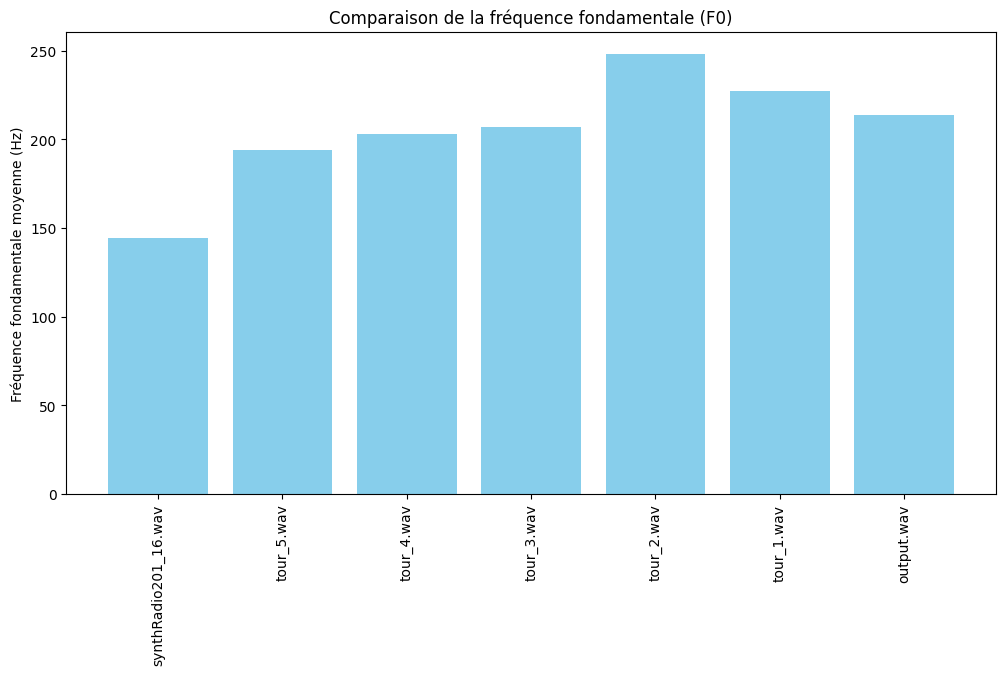

In [ ]:
# Charger les résultats
df = pd.read_csv(OUTPUT_CSV)

# Tracer F0 moyen par type de fichier
plt.figure(figsize=(12,6))
plt.bar(df["filename"], df["avg_f0"], color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Fréquence fondamentale moyenne (Hz)")
plt.title("Comparaison de la fréquence fondamentale (F0)")
plt.show()

## Pour les 25 tours de parole

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import soundfile as sf

# 📌 Dossiers contenant les fichiers audio
AUDIO_DIR_ORIGINAL = "/Users/chloe/Downloads/M2/Montacie/"
AUDIO_DIR_SYNTH = "/Users/chloe/Downloads/M2/Montacie/synthesized_audio/"

# 📌 Fichier de sortie pour les résultats
OUTPUT_CSV = os.path.join(AUDIO_DIR_ORIGINAL, "prosody_analysis_librosa.csv")

# 📌 Création du DataFrame pour stocker les résultats
results = []

# 📌 Fonction pour extraire les caractéristiques prosodiques avec Librosa
def extract_prosody_features(file_path):
    """Extrait F0, durée, intensité et pauses avec Librosa"""
    y, sr = librosa.load(file_path, sr=16000)

    # Extraction de la fréquence fondamentale (F0) avec Librosa
    f0_values, voiced_flag, _ = librosa.pyin(y, fmin=75, fmax=600, sr=sr)
    f0_values = f0_values[~np.isnan(f0_values)]  # Supprimer les valeurs NaN

    # Extraction de l'intensité (RMS Energy)
    rms = librosa.feature.rms(y=y)[0]

    # Détection des pauses (segments de silence)
    intervals = librosa.effects.split(y, top_db=25)
    num_pauses = len(intervals) - 1  # Nombre de pauses détectées

    # Calcul des statistiques
    avg_f0 = np.mean(f0_values) if len(f0_values) > 0 else 0
    std_f0 = np.std(f0_values) if len(f0_values) > 0 else 0
    avg_intensity = np.mean(rms)
    duration = librosa.get_duration(y=y, sr=sr)

    return avg_f0, std_f0, avg_intensity, num_pauses, duration

# 📌 Fonction pour analyser les fichiers d'un dossier
def analyze_directory(directory, label):
    for file in tqdm(os.listdir(directory), desc=f"📊 Analyse {label}"):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            avg_f0, std_f0, avg_intensity, num_pauses, duration = extract_prosody_features(file_path)

            results.append({
                "filename": file,
                "source": label,  # Indiquer si c'est "original" ou "synthesized"
                "avg_f0": avg_f0,
                "std_f0": std_f0,
                "avg_intensity": avg_intensity,
                "num_pauses": num_pauses,
                "duration": duration
            })

# 📌 Analyse des fichiers originaux et synthétisés
analyze_directory(AUDIO_DIR_ORIGINAL, "original")
analyze_directory(AUDIO_DIR_SYNTH, "synthesized")

# 📌 Sauvegarde des résultats
df_results = pd.DataFrame(results)
df_results.to_csv(OUTPUT_CSV, index=False)

print(f"✅ Analyse prosodique terminée. Résultats enregistrés dans {OUTPUT_CSV}")

📊 Analyse synthesized: 100%|██████████| 26/26 [00:12<00:00,  2.11it/s]

✅ Analyse prosodique terminée. Résultats enregistrés dans /Users/chloe/Downloads/M2/Montacie/prosody_analysis_librosa.csv


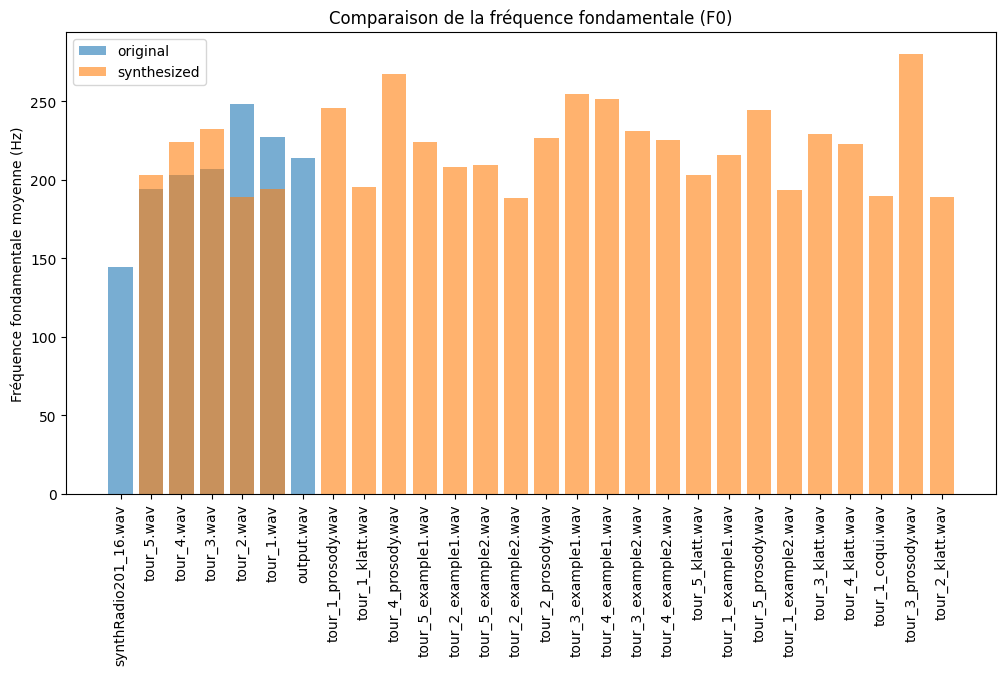

In [ ]:
# Charger les résultats
df = pd.read_csv(OUTPUT_CSV)

# Comparer F0 moyen des fichiers originaux et synthétisés
plt.figure(figsize=(12,6))
for label in ["original", "synthesized"]:
    subset = df[df["source"] == label]
    plt.bar(subset["filename"], subset["avg_f0"], label=label, alpha=0.6)

plt.xticks(rotation=90)
plt.ylabel("Fréquence fondamentale moyenne (Hz)")
plt.title("Comparaison de la fréquence fondamentale (F0)")
plt.legend()
plt.show()

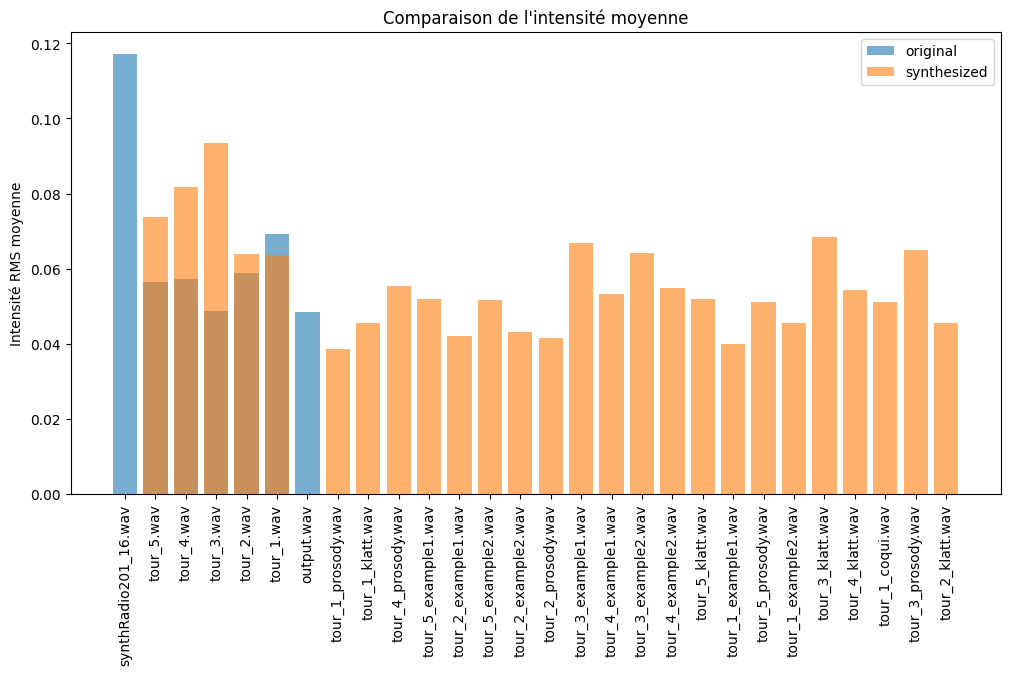

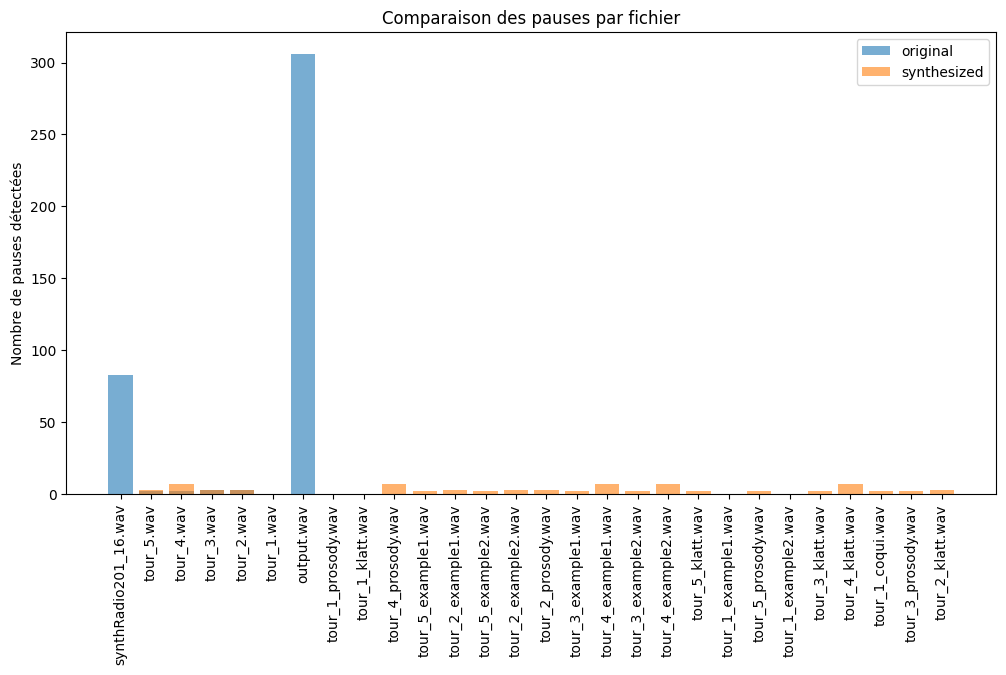

In [ ]:
# 🔹 Intensité moyenne
plt.figure(figsize=(12,6))
for label in ["original", "synthesized"]:
    subset = df[df["source"] == label]
    plt.bar(subset["filename"], subset["avg_intensity"], label=label, alpha=0.6)

plt.xticks(rotation=90)
plt.ylabel("Intensité RMS moyenne")
plt.title("Comparaison de l'intensité moyenne")
plt.legend()
plt.show()

# 🔹 Nombre de pauses
plt.figure(figsize=(12,6))
for label in ["original", "synthesized"]:
    subset = df[df["source"] == label]
    plt.bar(subset["filename"], subset["num_pauses"], label=label, alpha=0.6)

plt.xticks(rotation=90)
plt.ylabel("Nombre de pauses détectées")
plt.title("Comparaison des pauses par fichier")
plt.legend()
plt.show()

In [ ]:
import os
import torch
import librosa
import numpy as np
import pandas as pd
import joblib
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# 📌 Définition des chemins pour ton projet
wav_dir = "/Users/chloe/Downloads/M2/Montacie/synthesized_audio"  # 📂 Tes fichiers audio
csv_file = "/Users/chloe/Downloads/M2/Montacie/paralinguistic_labels.csv"  # 📄 Labels agréables/désagréables

# 📌 Vérifier l'utilisation du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 Charger le modèle Wav2Vec
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(device)

# 📌 Extraction des caractéristiques audio
def extract_features(file_path):
    """Extrait des caractéristiques audio avec Wav2Vec et Librosa."""
    try:
        audio, sr = librosa.load(file_path, sr=16000)

        # 🔹 Extraction de Pitch (F0) et Intensity
        f0, _, _ = librosa.pyin(audio, fmin=75, fmax=600, sr=sr)
        mean_f0 = np.nanmean(f0) if np.any(np.isfinite(f0)) else 0  # Moyenne de F0
        std_f0 = np.nanstd(f0) if np.any(np.isfinite(f0)) else 0    # Variabilité du F0
        mean_intensity = np.mean(np.abs(audio))  # Intensité moyenne

        # 🔹 Extraction avec Wav2Vec2
        inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            features = model(**inputs).last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

        # 🔹 Concaténer Pitch, Intensité et Embeddings Wav2Vec
        return np.concatenate(([mean_f0, std_f0, mean_intensity], features))
    except Exception as e:
        print(f"⚠ Erreur sur {file_path}: {e}")
        return None

# 📌 Charger les données et extraire les features
def load_data():
    df = pd.read_csv(csv_file)
    X, y = [], []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="📊 Extraction des caractéristiques"):
        file_name, label = row['filename'], row['type']
        file_path = os.path.join(wav_dir, file_name)
        features = extract_features(file_path)

        if features is not None:
            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

# 📌 Charger les données
X, y = load_data()

# 📌 Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 📌 Sauvegarde du label encoder
label_encoder_path = "/Users/chloe/Downloads/M2/Montacie/label_encoder.pkl"
joblib.dump(label_encoder, label_encoder_path)
print(f"✅ Label encoder sauvegardé à {label_encoder_path}")

# 📌 Entraînement du modèle SVM avec n_splits=2
param_grid = {'C': np.logspace(-3, 3, 10)}
svm_model = SVC(kernel='linear')
grid_search = GridSearchCV(svm_model, param_grid, cv=2)  # 🔹 Mise à jour ici
grid_search.fit(X, y_encoded)

# 📌 Sauvegarde du modèle entraîné
model_path = "/Users/chloe/Downloads/M2/Montacie/best_svm_model.pkl"
joblib.dump(grid_search.best_estimator_, model_path)
print(f"✅ Modèle SVM sauvegardé à {model_path}")

# 📌 Évaluation du modèle
y_pred = grid_search.best_estimator_.predict(X)
accuracy = accuracy_score(y_encoded, y_pred)

print(f"📊 Meilleur paramètre C: {grid_search.best_params_['C']}")
print(f"🎯 Précision du modèle: {accuracy * 100:.2f}%")

/opt/anaconda3/lib/python3.10/site-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
📊 Extraction des caractéristiques: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

✅ Label encoder sauvegardé à /Users/chloe/Downloads/M2/Montacie/label_encoder.pkl
✅ Modèle SVM sauvegardé à /Users/chloe/Downloads/M2/Montacie/best_svm_model.pkl
📊 Meilleur paramètre C: 0.001
🎯 Précision du modèle: 60.00%
